# Problem Statement
---
This project aims to create a model that identifies potential fraudulent applicants of US government loans (Paycheck Protection Program) and provide insight on key variables that authorities should focus on when approving future applications.

## Importing Libs and dataset

In [1]:
# import necessary libs
import numpy as np
import pandas as pd

import os 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# this is basically your labels which you need to encode it inside alr
ppp_dict = pd.read_csv('ppp_data_dict.csv')

# how fraud case would look like
fraud_data = pd.read_csv('ppp_fraud_cases.csv')

data = pd.read_csv('ppp_over_150k.csv')

transformed_data = pd.read_csv('ppp_transformed.csv')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968532 entries, 0 to 968531
Data columns (total 66 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   LoanNumber                     968532 non-null  int64  
 1   DateApproved                   968532 non-null  object 
 2   SBAOfficeCode                  968532 non-null  int64  
 3   ProcessingMethod               968532 non-null  object 
 4   BorrowerName                   968525 non-null  object 
 5   BorrowerAddress                968532 non-null  object 
 6   BorrowerCity                   968532 non-null  object 
 7   BorrowerState                  968532 non-null  object 
 8   BorrowerZip                    968532 non-null  object 
 9   LoanStatusDate                 968532 non-null  object 
 10  LoanStatus                     968532 non-null  object 
 11  Term                           968532 non-null  int64  
 12  SBAGuarantyPercentage         

In [3]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961899 entries, 0 to 961898
Data columns (total 68 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   LoanNumber                                  961899 non-null  int64  
 1   DateApproved                                961899 non-null  object 
 2   SBAOfficeCode                               961899 non-null  int64  
 3   ProcessingMethod                            961899 non-null  object 
 4   BorrowerName                                961892 non-null  object 
 5   BorrowerCity                                961899 non-null  object 
 6   BorrowerState                               961899 non-null  object 
 7   BorrowerZip                                 961899 non-null  object 
 8   LoanStatus                                  961899 non-null  object 
 9   Term                                        961899 non-null  int64  
 

In [13]:
column_names = transformed_data.columns.tolist()
column_names

['LoanNumber',
 'DateApproved',
 'SBAOfficeCode',
 'ProcessingMethod',
 'BorrowerName',
 'BorrowerCity',
 'BorrowerState',
 'BorrowerZip',
 'LoanStatus',
 'Term',
 'InitialApprovalAmount',
 'CurrentApprovalAmount',
 'FranchiseName',
 'ServicingLenderName',
 'ServicingLenderZip',
 'RuralUrbanIndicator',
 'HubzoneIndicator',
 'LMIIndicator',
 'BusinessAgeDescription',
 'ProjectCity',
 'JobsReported',
 'NAICSCode',
 'Race',
 'Ethnicity',
 'BusinessType',
 'Gender',
 'Veteran',
 'TOTAL_PROCEED',
 'PROCEED_Diff',
 'UTILITIES_PROCEED_pct',
 'PAYROLL_PROCEED_pct',
 'MORTGAGE_INTEREST_PROCEED_pct',
 'RENT_PROCEED_pct',
 'REFINANCE_EIDL_PROCEED_pct',
 'HEALTH_CARE_PROCEED_pct',
 'DEBT_INTEREST_PROCEED_pct',
 'PROCEED_Per_Job',
 'isAfterBiden',
 'isDiffBorrowerAndProjectCity',
 'Industry',
 'Subsector',
 'ProcessingMethod_encoded',
 'LoanStatus_encoded',
 'RuralUrbanIndicator_encoded',
 'HubzoneIndicator_encoded',
 'LMIIndicator_encoded',
 'BusinessAgeDescription_encoded',
 'Race_encoded',
 'Eth

## Preparing the dataset

In [17]:
# Columns to retain
columns_to_retain = ['CurrentApprovalAmount', 'JobsReported', 'PROCEED_Diff', 'UTILITIES_PROCEED_pct',
                     'PAYROLL_PROCEED_pct', 'MORTGAGE_INTEREST_PROCEED_pct', 'RENT_PROCEED_pct',
                     'REFINANCE_EIDL_PROCEED_pct', 'HEALTH_CARE_PROCEED_pct', 'DEBT_INTEREST_PROCEED_pct',
                     'PROCEED_Per_Job', 'isAfterBiden', 'isDiffBorrowerAndProjectCity', 'ProcessingMethod_encoded',
                     'LoanStatus_encoded', 'HubzoneIndicator_encoded', 'LMIIndicator_encoded',
                     'BusinessAgeDescription_encoded', 'Race_encoded', 'Ethnicity_encoded', 'BusinessType_encoded',
                     'Gender_encoded', 'Veteran_encoded', 'Industry_encoded', 'Term_standardised',
                     'JobsReported_standardised', 'PROCEED_Diff_standardised', 'UTILITIES_PROCEED_pct_standardised',
                     'PAYROLL_PROCEED_pct_standardised', 'MORTGAGE_INTEREST_PROCEED_pct_standardised',
                     'RENT_PROCEED_pct_standardised', 'REFINANCE_EIDL_PROCEED_pct_standardised',
                     'HEALTH_CARE_PROCEED_pct_standardised', 'DEBT_INTEREST_PROCEED_pct_standardised',
                     'InitialApprovalAmount_scaled_standardised', 'CurrentApprovalAmount_scaled_standardised',
                     'TOTAL_PROCEED_scaled_standardised', 'PROCEED_Per_Job_scaled_standardised', 'isFraud']

# Retain the specified columns
selected_data = transformed_data.loc[:, columns_to_retain]

# Display the retained DataFrame
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961899 entries, 0 to 961898
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   CurrentApprovalAmount                       961899 non-null  float64
 1   JobsReported                                961899 non-null  int64  
 2   PROCEED_Diff                                961899 non-null  float64
 3   UTILITIES_PROCEED_pct                       961899 non-null  float64
 4   PAYROLL_PROCEED_pct                         961899 non-null  float64
 5   MORTGAGE_INTEREST_PROCEED_pct               961899 non-null  float64
 6   RENT_PROCEED_pct                            961899 non-null  float64
 7   REFINANCE_EIDL_PROCEED_pct                  961899 non-null  float64
 8   HEALTH_CARE_PROCEED_pct                     961899 non-null  float64
 9   DEBT_INTEREST_PROCEED_pct                   961899 non-null  float64
 



## Understanding the data

- To understand how a fraud case would be like it would be suggested to see the links provided in ```ppp_fraud_cases.csv``` file.

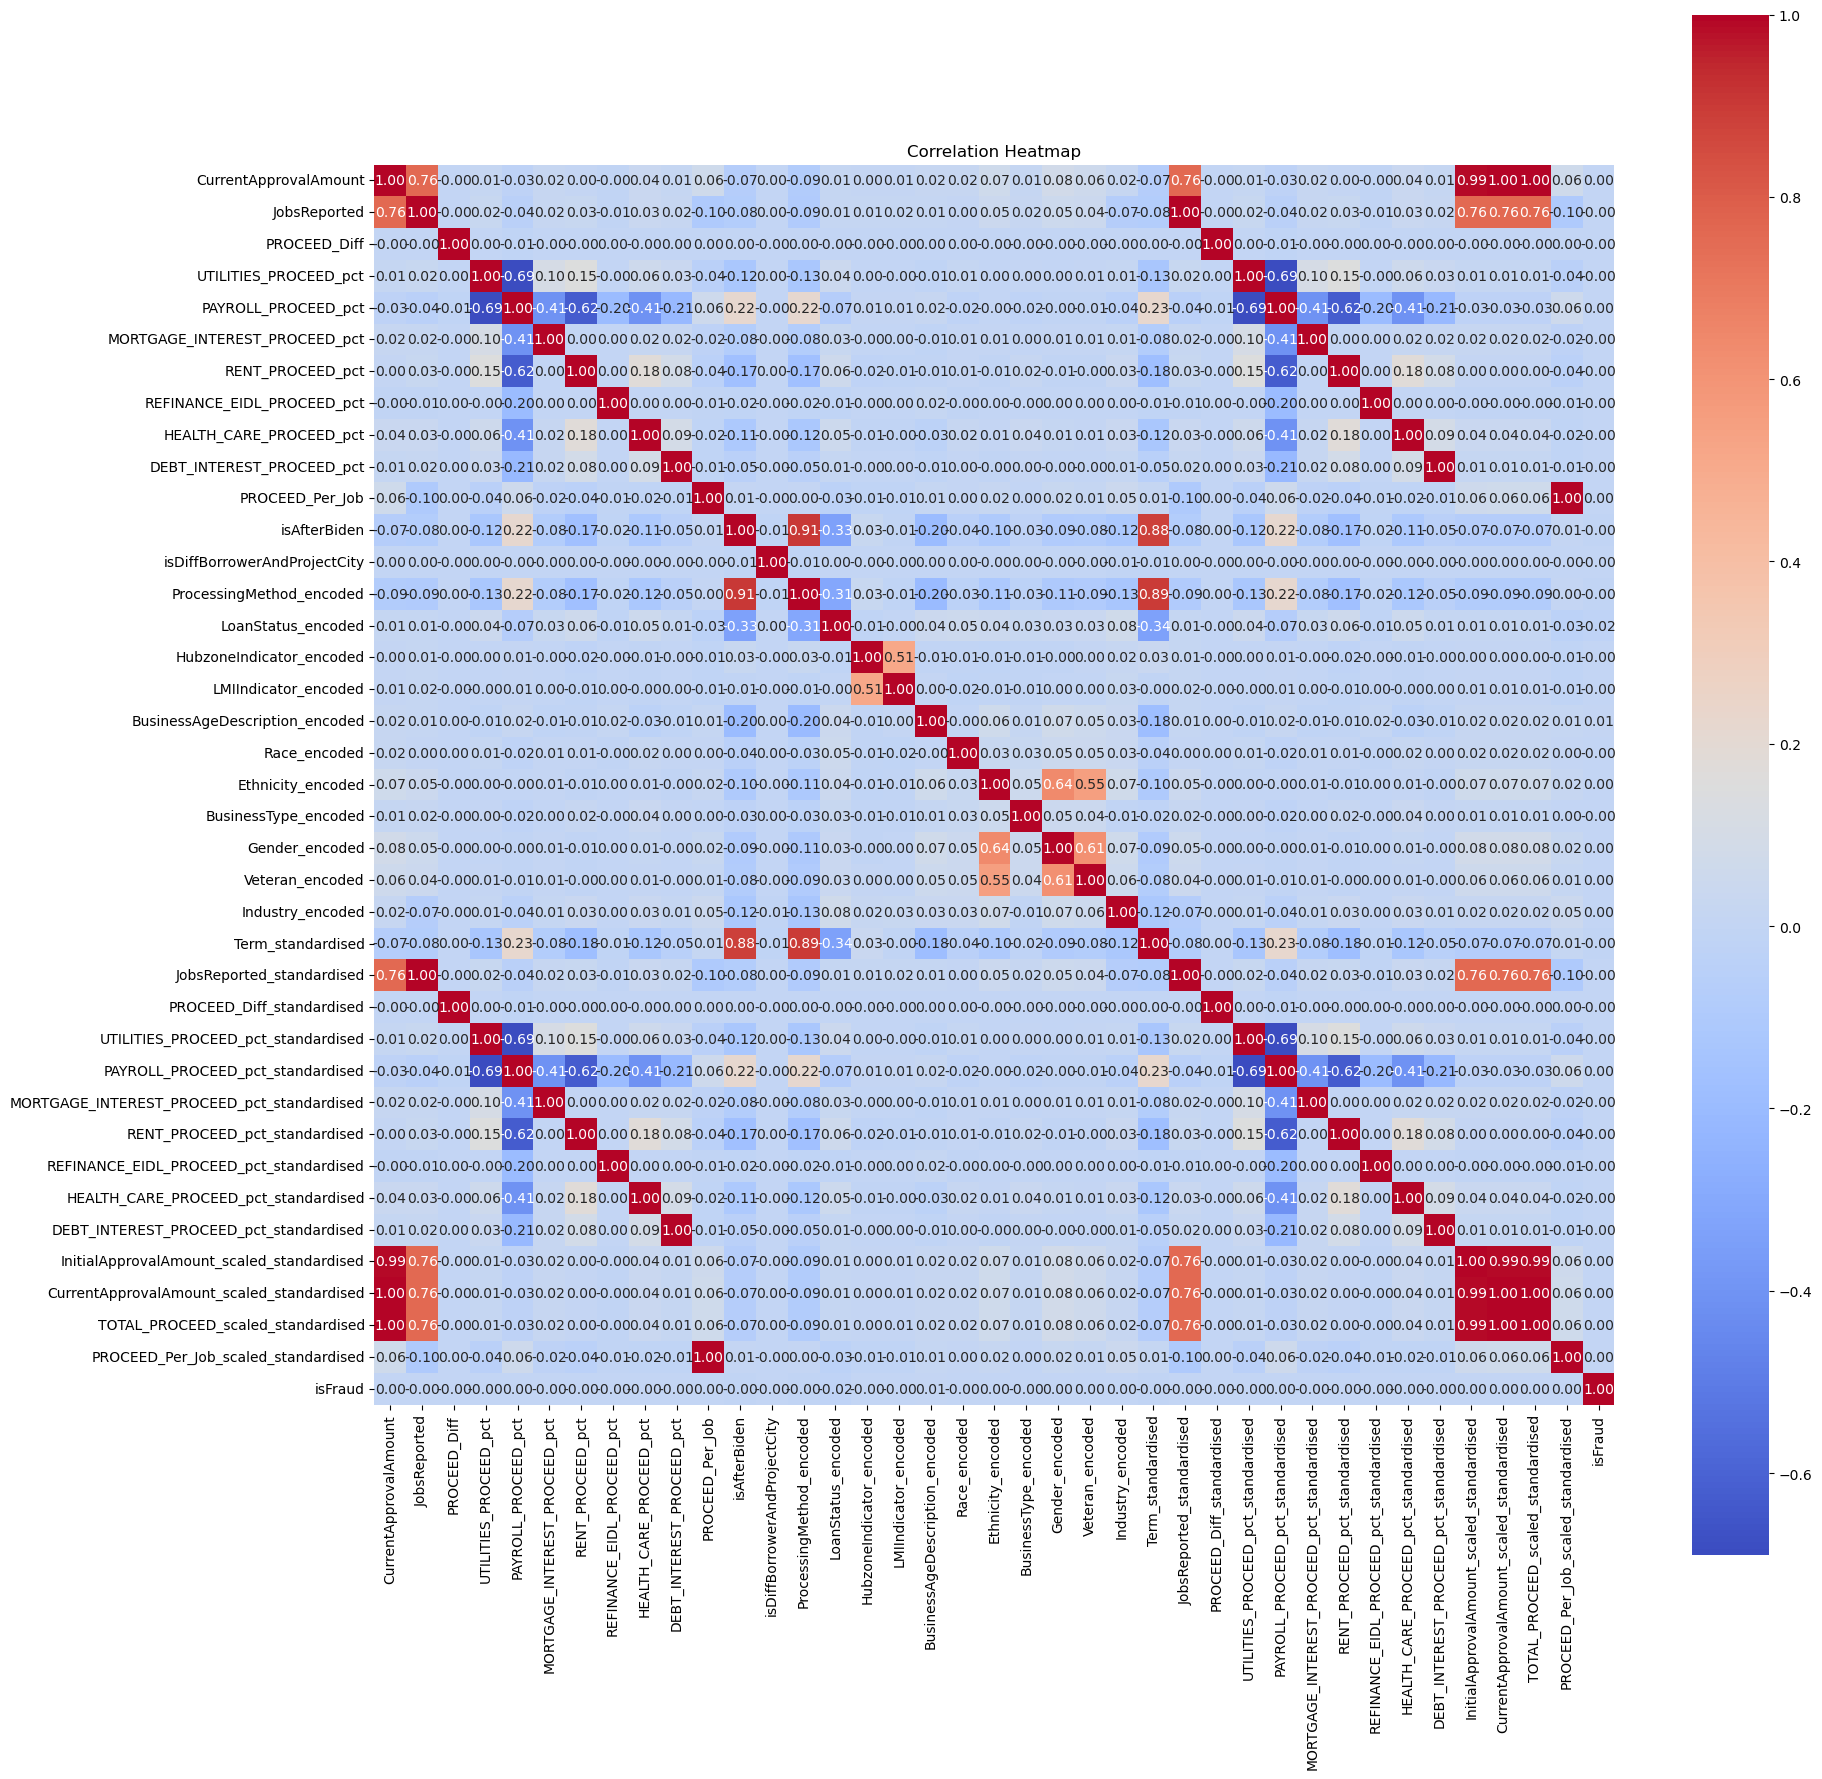

In [18]:
# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

## Check out the data

In [21]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961899 entries, 0 to 961898
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   CurrentApprovalAmount                       961899 non-null  float64
 1   JobsReported                                961899 non-null  int64  
 2   PROCEED_Diff                                961899 non-null  float64
 3   UTILITIES_PROCEED_pct                       961899 non-null  float64
 4   PAYROLL_PROCEED_pct                         961899 non-null  float64
 5   MORTGAGE_INTEREST_PROCEED_pct               961899 non-null  float64
 6   RENT_PROCEED_pct                            961899 non-null  float64
 7   REFINANCE_EIDL_PROCEED_pct                  961899 non-null  float64
 8   HEALTH_CARE_PROCEED_pct                     961899 non-null  float64
 9   DEBT_INTEREST_PROCEED_pct                   961899 non-null  float64
 

## Naive Bayes Modelling

In [22]:
# Fix randomness
np.random.seed(55)

# Set independent and dependent attributes
Independent = selected_data_copy = selected_data.copy().drop(["isFraud"], axis=1)
Dependent = selected_data["isFraud"]

In [23]:
# Split data to train 
X_train, X_test, y_train, y_test = train_test_split(Independent, Dependent, test_size=0.2, random_state=55, stratify=Dependent)

In [24]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (769519, 38)
X_test shape: (192380, 38)
y_train shape: (769519,)
y_test shape: (192380,)


In [25]:
gnb = GaussianNB()
predictions = gnb.fit(X_train, y_train).predict(X_test)

## Confusion Matrix

In [26]:
# Making confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[192056    306]
 [    18      0]]


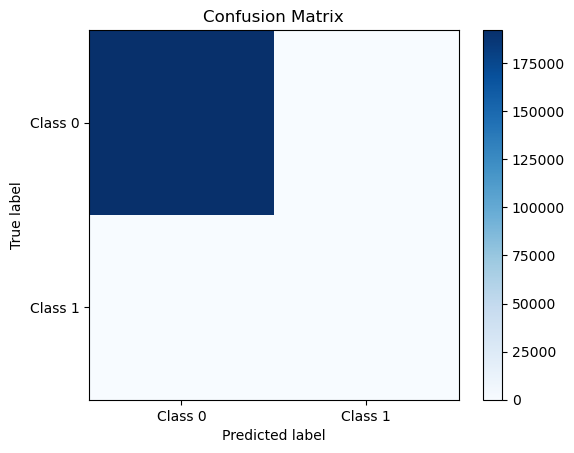

In [27]:
# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Class 0', 'Class 1']  # Modify based on your classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192362
           1       0.00      0.00      0.00        18

    accuracy                           1.00    192380
   macro avg       0.50      0.50      0.50    192380
weighted avg       1.00      1.00      1.00    192380



In [29]:
# Split data to train 
X_train, X_test, y_train, y_test = train_test_split(Independent, Dependent, test_size=0.2, random_state=55)
#Apply Over Sampling
print('Before Oversampling')
print(sorted(Counter(y_train).items()))

smote = SMOTE(random_state=55)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

print('After Oversampling:')
print(sorted(Counter(y_train_oversampled).items()))

Before Oversampling
[(0, 769448), (1, 71)]


  File "C:\Users\ngzha\anac3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


After Oversampling:
[(0, 769448), (1, 769448)]


In [30]:
gnb = GaussianNB()
predictions = gnb.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192362
           1       0.00      0.00      0.00        18

    accuracy                           1.00    192380
   macro avg       0.50      0.50      0.50    192380
weighted avg       1.00      1.00      1.00    192380



In [31]:
# Split data to train 
X_train, X_test, y_train, y_test = train_test_split(Independent, Dependent, test_size=0.2, random_state=55)

#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=55)
X_train, y_train =rus.fit_resample(X_train, y_train)

In [32]:
gnb = GaussianNB()
predictions = gnb.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    192362
           1       0.00      0.28      0.00        18

    accuracy                           0.91    192380
   macro avg       0.50      0.59      0.48    192380
weighted avg       1.00      0.91      0.95    192380



## AdaBoost